In [5]:
!pip install pyfolio-reloaded

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functools import partial

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import(train_test_split, TimeSeriesSplit)

from sklearn.metrics import(accuracy_score, classification_report, 
                            RocCurveDisplay, ConfusionMatrixDisplay, 
                            log_loss)

import optuna

In [7]:
df = pd.read_csv('niftyindex.csv', index_col=0, parse_dates=True, 
                dayfirst=True)
df

Open      High       Low     Close     Volume
2012-01-02   4640.20   4645.95   4588.05   4636.75  108461000
2012-01-03   4675.80   4773.10   4675.80   4765.30  146621008
2012-01-04   4774.95   4782.85   4728.85   4749.65  165939008
2012-01-05   4749.00   4779.80   4730.15   4749.95  177863008
2012-01-06   4724.15   4794.90   4686.85   4754.10  176057008
...              ...       ...       ...       ...        ...
2022-12-26  17830.40  18084.10  17774.25  18014.60  176652336
2022-12-27  18089.80  18149.25  17967.45  18132.30  214257088
2022-12-28  18084.75  18173.10  18068.35  18122.50  193873168
2022-12-29  18045.70  18229.70  17992.80  18191.00  281052832
2022-12-30  18259.10  18265.25  18080.30  18105.30  192005568

[2719 rows x 5 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2719 entries, 2012-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2719 non-null   float64
 1   High    2719 non-null   float64
 2   Low     2719 non-null   float64
 3   Close   2719 non-null   float64
 4   Volume  2719 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 127.5 KB


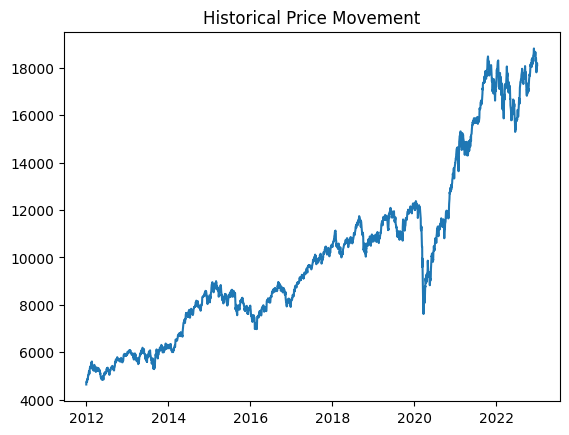

In [9]:
plt.plot(df['Close'])
plt.title('Historical Price Movement');

In [10]:
df.describe().T

count          mean           std         min           25%  \
Open    2719.0  1.012490e+04  3.709607e+03     4640.20  7.637000e+03   
High    2719.0  1.017529e+04  3.725527e+03     4645.95  7.681000e+03   
Low     2719.0  1.005747e+04  3.685305e+03     4588.05  7.581650e+03   
Close   2719.0  1.011757e+04  3.706945e+03     4636.75  7.623800e+03   
Volume  2719.0  2.892221e+08  1.952768e+08  2826000.00  1.591780e+08   

                 50%           75%           max  
Open    9.376950e+03  1.170085e+04  1.887195e+04  
High    9.431900e+03  1.175512e+04  1.888760e+04  
Low     9.301350e+03  1.163133e+04  1.877820e+04  
Close   9.351850e+03  1.168400e+04  1.881250e+04  
Volume  2.194961e+08  3.409088e+08  1.810971e+09

In [11]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [12]:
#Features

#df['HC'] = df['High'] - df['Close']
df['RET'] = np.log(df['Close'] / df['Close'].shift(1))
df['MA7'] = df['Close'] / df['Close'].rolling(7).mean()
df['VMA'] = df['Volume'] / df['Volume'].rolling(7).mean()

df['OC_'] = df['Close'] / df['Open'] - 1
df['OC'] = df['OC_'].rolling(7).mean()

df['HL_'] = df['High'] / df['Low'] - 1
df['HL'] = df['HL_'].rolling(7).mean()

df['GAP_'] = df['Open'] / df['Close'].shift(1) - 1
df['GAP'] = df['GAP_'].rolling(7).mean()

df['STD'] = df['RET'].rolling(7).std()
df['UB'] = df['Close'].rolling(7).mean() + df['Close'].rolling(7).std()*2

df.dropna(inplace=True)

features = df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 
                   'OC_', 'HL_', 'GAP_'], axis=1)

features

RET       MA7       VMA        OC        HL       GAP  \
2012-01-11  0.002348  1.016561  1.194981  0.005030  0.014998  0.001776   
2012-01-12 -0.006129  1.008364  1.016079  0.002010  0.013967 -0.000015   
2012-01-13  0.007167  1.012105  1.218956  0.002886  0.014246  0.000603   
2012-01-16  0.001622  1.010029  0.858298  0.003739  0.014337 -0.000023   
2012-01-17  0.018982  1.022928  1.151396  0.004662  0.013128  0.001650   
...              ...       ...       ...       ...       ...       ...   
2022-12-26  0.011602  0.991193  0.894157 -0.001978  0.013594 -0.001114   
2022-12-27  0.006512  0.998743  1.136602 -0.001252  0.013586  0.000225   
2022-12-28 -0.000541  1.000549  0.998925 -0.001988  0.012949 -0.000299   
2022-12-29  0.003773  1.005872  1.337815 -0.001188  0.013243 -0.000283   
2022-12-30 -0.004722  1.001875  0.911216 -0.000562  0.012261 -0.000135   

                 STD            UB  
2012-01-11  0.012567   4883.289920  
2012-01-12  0.009388   4897.701556  
2012-01-13  0.009243   4920.229059  
2012-01-16  0.009166   4934.405343  
2012-01-17  0.010674   4988.380293  
...              ...           ...  
2022-12-26  0.010314  18604.740625  
2022-12-27  0.010633  18577.567284  
2022-12-28  0.009836  18464.387000  
2022-12-29  0.010107  18358.111628  
2022-12-30  0.009521  18327.197672  

[2712 rows x 8 columns]

In [13]:
X = features.values

In [14]:
#label

y = np.where(df['Close'].shift(-1) > 0.995*df['Close'], 1, 0)

pd.Series(y).value_counts()

1    2065
0     647
Name: count, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [16]:
classifier = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(class_weight='balanced'))
])

classifier.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(class_weight='balanced'))])

In [17]:
classifier.classes_

array([0, 1])

In [18]:
y_pred = classifier.predict(X_test)
y_pred[-20:]

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [19]:
y_proba = classifier.predict_proba(X_test)
y_proba[-20:]

array([[0.49306414, 0.50693586],
       [0.53439343, 0.46560657],
       [0.53764974, 0.46235026],
       [0.51080912, 0.48919088],
       [0.5328059 , 0.4671941 ],
       [0.52624428, 0.47375572],
       [0.49449748, 0.50550252],
       [0.47498153, 0.52501847],
       [0.54435241, 0.45564759],
       [0.50744332, 0.49255668],
       [0.50474601, 0.49525399],
       [0.52523453, 0.47476547],
       [0.55117023, 0.44882977],
       [0.54171702, 0.45828298],
       [0.59363628, 0.40636372],
       [0.51531085, 0.48468915],
       [0.48927945, 0.51072055],
       [0.51188722, 0.48811278],
       [0.46152452, 0.53847548],
       [0.52704391, 0.47295609]])

In [20]:
acc_train = accuracy_score(y_train, classifier.fit(X_train, y_train).predict(X_train))

acc_test = accuracy_score(y_test, classifier.predict(X_test))

print("Baseline Model")
print("Train Accuracy:", acc_train)
print("Test Accuracy:", acc_test)

Baseline Model
Train Accuracy: 0.5744582757030889
Test Accuracy: 0.5395948434622467


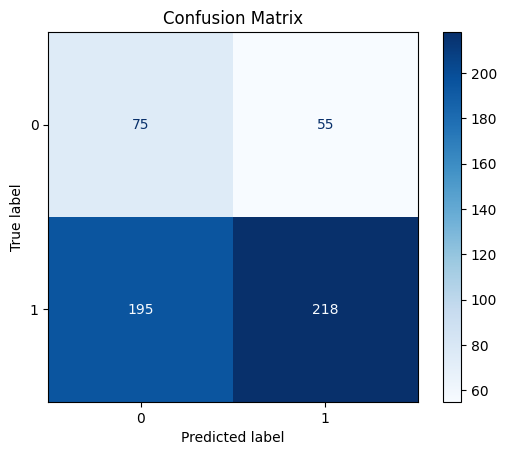

In [21]:
#confussion matrix

disp = ConfusionMatrixDisplay.from_estimator(classifier,
                                             X_test, 
                                             y_test, 
                                             cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

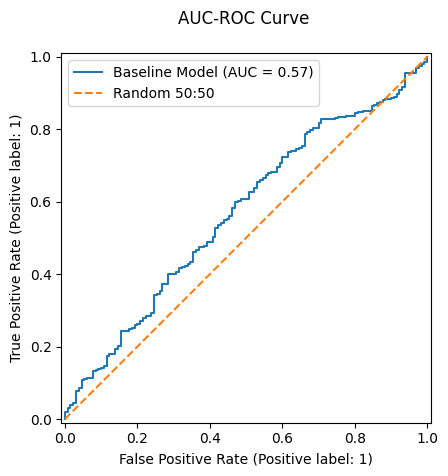

In [22]:
#ROC Curve

disp = RocCurveDisplay.from_estimator(classifier,
                                     X_test, 
                                     y_test,
                                     name='Baseline Model')
plt.title('AUC-ROC Curve \n')
plt.plot([0,1],[0,1], linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [23]:
#classification report

print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.28      0.58      0.38       130
           1       0.80      0.53      0.64       413

    accuracy                           0.54       543
   macro avg       0.54      0.55      0.51       543
weighted avg       0.67      0.54      0.57       543



In [24]:
classifier.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', LogisticRegression(class_weight='balanced'))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': LogisticRegression(class_weight='balanced'),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__C': 1.0,
 'classifier__class_weight': 'balanced',
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'auto',
 'classifier__n_jobs': None,
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__solver': 'lbfgs',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [25]:
### TimeSeries Split (Forward Chaining example)

tscv = TimeSeriesSplit(n_splits=2, gap=1)

for idx in tscv.split(X):
    print(idx[0], idx[1])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [26]:
# Use Optuna for Tuning
# Define Objective Function

def optimize(trial, x, y):
    
    tolerance = trial.suggest_float("tol", 0.001, 0.01, log=True)
    regularization = trial.suggest_float('C', 0.001, 1, log=True)
    
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(C=regularization,
                                    tol=tolerance,
                                    class_weight='balanced'))
    ])
    
    tscv = TimeSeriesSplit(n_splits=10, gap=1)
    logloss = []
    
    for idx in tscv.split(x):
        train_idx, test_idx = idx[0], idx[1]
        
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        
        xtest = x[test_idx]
        ytest = y[test_idx]
        
        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        
        logloss.append(log_loss(ytest, preds))
        
    return -1.0 * np.mean(logloss)

In [27]:
study = optuna.create_study(study_name='hp_lr',
                           direction='minimize')

[I 2024-05-19 03:27:28,524] A new study created in memory with name: hp_lr


In [28]:
optimization_function = partial(optimize, x=X, y=y)
study.optimize(optimization_function, n_trials=20)

[I 2024-05-19 03:27:28,570] Trial 0 finished with value: -15.03284080375374 and parameters: {'tol': 0.002951384574097993, 'C': 0.009361065734804322}. Best is trial 0 with value: -15.03284080375374.
[I 2024-05-19 03:27:28,594] Trial 1 finished with value: -14.622587838349153 and parameters: {'tol': 0.005399650275710042, 'C': 0.3183273175405341}. Best is trial 0 with value: -15.03284080375374.
[I 2024-05-19 03:27:28,615] Trial 2 finished with value: -15.106100261861698 and parameters: {'tol': 0.007619015591443864, 'C': 0.5371981307038739}. Best is trial 2 with value: -15.106100261861698.
[I 2024-05-19 03:27:28,650] Trial 3 finished with value: -14.344201897538898 and parameters: {'tol': 0.0025315562730144248, 'C': 0.14606251726734087}. Best is trial 2 with value: -15.106100261861698.
[I 2024-05-19 03:27:28,683] Trial 4 finished with value: -15.062144586996919 and parameters: {'tol': 0.0012334048156832447, 'C': 0.006511641040352916}. Best is trial 2 with value: -15.106100261861698.
[I 202

In [29]:
print("Best Params:", study.best_params)
print("Best Value:", study.best_value)

Best Params: {'tol': 0.005938118920189275, 'C': 0.0028913815752685387}
Best Value: -15.604264576995837


In [30]:
optuna.visualization.plot_optimization_history(study)

In [31]:
optuna.visualization.plot_param_importances(study)

In [32]:
optuna.visualization.plot_slice(study)

In [33]:
optuna.visualization.plot_contour(study, params=['tol', 'C'])

In [34]:
optuna.visualization.plot_parallel_coordinate(study)

In [35]:
# Tuned Model

clf = Pipeline([("scaler", StandardScaler()),
               ("estimator", LogisticRegression(tol=study.best_params['tol'],
                                               C=study.best_params['C'],
                                               class_weight='balanced'))])

clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 LogisticRegression(C=0.0028913815752685387,
                                    class_weight='balanced',
                                    tol=0.005938118920189275))])

In [36]:
y_pred = clf.predict(X_test)

y_pred[-20:]

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [37]:
acc_train = accuracy_score(y_train, clf.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)

print("Tuned Model")
print("Train Accuracy:", acc_train)
print("Test Accuracy:", acc_test)

Tuned Model
Train Accuracy: 0.5726141078838174
Test Accuracy: 0.5930018416206262


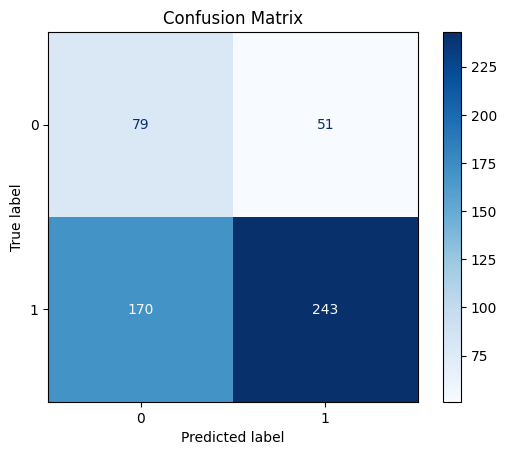

In [38]:
disp = ConfusionMatrixDisplay.from_estimator(clf, 
                                            X_test,
                                            y_test,
                                            cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()

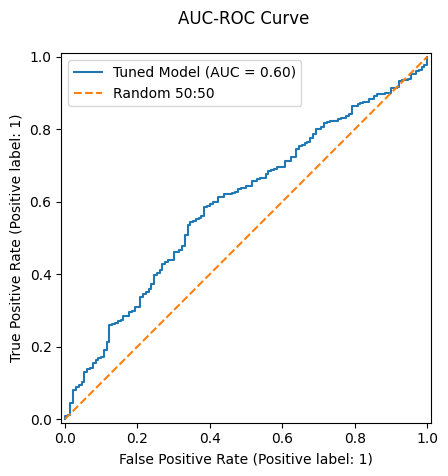

In [39]:
disp = RocCurveDisplay.from_estimator(clf,
                                     X_test,
                                     y_test,
                                     name='Tuned Model')

plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1], linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.61      0.42       130
           1       0.83      0.59      0.69       413

    accuracy                           0.59       543
   macro avg       0.57      0.60      0.55       543
weighted avg       0.70      0.59      0.62       543



In [44]:
# Trading Strategy

df2 = pd.read_csv('niftyindex.csv', index_col=0, parse_dates=True, dayfirst=True)
df2 = df2.iloc[7:,:]

df2['Signal'] = clf.predict(X)

df2['Entry'] = np.where(df2['Signal']==1, df2['Close'], 0)

df2['Exit'] = np.where((df2['Entry']!=0) & 
                       (df2['Open'].shift(-1)<=df2['Close']),
                       df['Open'].shift(-1), 0)

df2['Exit'] = np.where((df2['Entry']!=0) & 
                       (df2['Open'].shift(-1)>df2['Close']),
                       df2['Close'].shift(-1), df2['Exit'])

df2['P&L'] = df2['Exit'] - df2['Entry']

df2['Equity'] = df2['P&L'].cumsum() + df2['Close'].iloc[0]

df2['Returns'] = np.log(df2['Close']).diff().fillna(0)

df2['Strategy'] = (df2['Equity'] / df2['Equity'].shift(1) - 1).fillna(0)

df2 = df2.iloc[:-1]

df2

Open      High       Low     Close     Volume  Signal  \
2012-01-11   4863.15   4877.20   4841.60   4860.95  209080000       1   
2012-01-12   4840.95   4869.20   4803.90   4831.25  183068992       0   
2012-01-13   4861.95   4898.85   4834.20   4866.00  230940992       1   
2012-01-16   4844.00   4880.80   4827.05   4873.90  160480000       1   
2012-01-17   4904.50   4975.55   4904.00   4967.30  223004000       1   
...              ...       ...       ...       ...        ...     ...   
2022-12-23  17977.65  18050.45  17779.50  17806.80  221454768       0   
2022-12-26  17830.40  18084.10  17774.25  18014.60  176652336       0   
2022-12-27  18089.80  18149.25  17967.45  18132.30  214257088       1   
2022-12-28  18084.75  18173.10  18068.35  18122.50  193873168       0   
2022-12-29  18045.70  18229.70  17992.80  18191.00  281052832       1   

               Entry      Exit    P&L    Equity   Returns  Strategy  
2012-01-11   4860.95   4840.95 -20.00   4840.95  0.000000  0.000000  
2012-01-12      0.00      0.00   0.00   4840.95 -0.006129  0.000000  
2012-01-13   4866.00   4844.00 -22.00   4818.95  0.007167 -0.004545  
2012-01-16   4873.90   4967.30  93.40   4912.35  0.001622  0.019382  
2012-01-17   4967.30   4955.80 -11.50   4900.85  0.018982 -0.002341  
...              ...       ...    ...       ...       ...       ...  
2022-12-23      0.00      0.00   0.00  19943.20 -0.017841  0.000000  
2022-12-26      0.00      0.00   0.00  19943.20  0.011602  0.000000  
2022-12-27  18132.30  18084.75 -47.55  19895.65  0.006512 -0.002384  
2022-12-28      0.00      0.00   0.00  19895.65 -0.000541  0.000000  
2022-12-29  18191.00  18105.30 -85.70  19809.95  0.003773 -0.004307  

[2711 rows x 12 columns]

In [42]:
import quantstats as qs
qs.reports.html(df2['Strategy'], df2['Returns'])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/Library/Frameworks/Python.fram

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyfolio/pos.py:25: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyfolio/plotting.py:670: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.122%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyfolio/plotting.py:670: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19.764%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyfolio/plotting.py:670: FutureWarning:

Setting

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyfolio/plotting.py:850: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyfolio/plotting.py:850: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



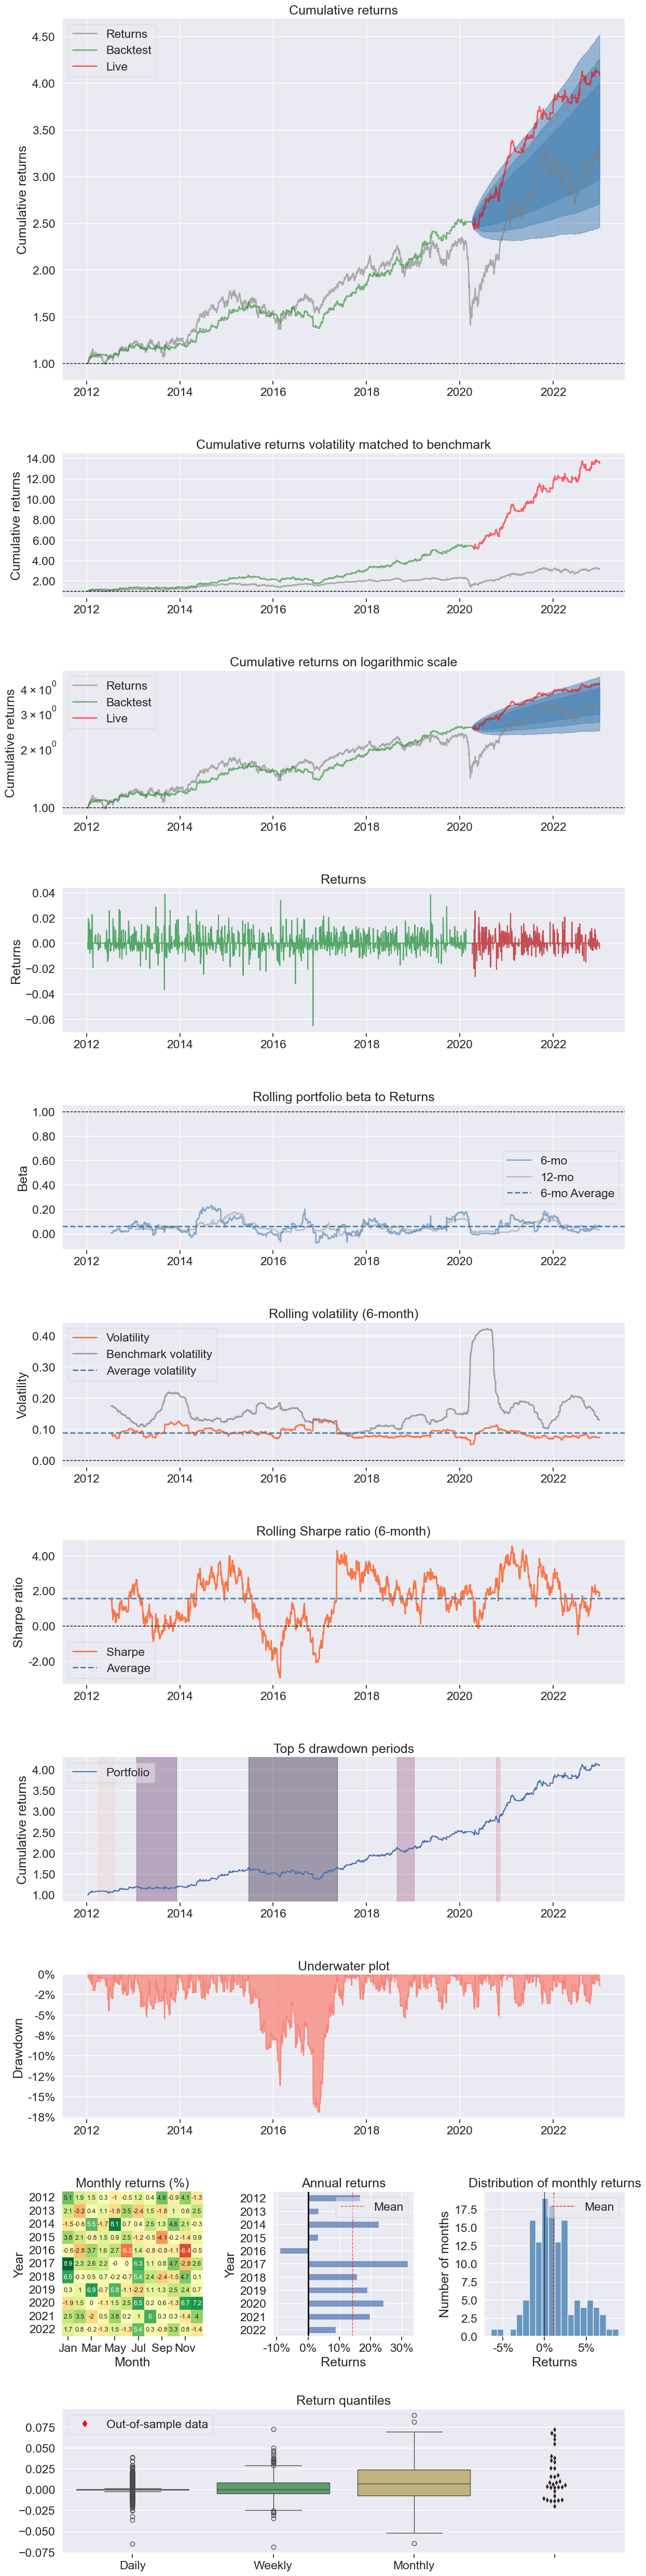

In [43]:
import pyfolio as pf

df3 = df2.copy()
df3.index = df3.index.tz_localize('utc')

pf.create_returns_tear_sheet(df3['Strategy'], 
                             live_start_date='2020-04-07',
                             benchmark_rets=df3['Returns'])